# Ocena jakości wina - projekt zespołowy PRiAD

Zaimportowanie bibliotek oraz wczytanie pliku z danymi

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

wineRed = pd.read_csv('data/winequality-red.csv', sep=";", usecols = range(0,12))
wineWhite = pd.read_csv('data/winequality-white.csv', sep=";", usecols = range(0,12))

### Przedstawienie informacji o zbiorze win czerwonych

Ilość brakujących danych: 0
Ilość obiektów: 1599
Atrybuty: 
	fixed acidity
	volatile acidity
	citric acid
	residual sugar
	chlorides
	free sulfur dioxide
	total sulfur dioxide
	density
	pH
	sulphates
	alcohol
	quality


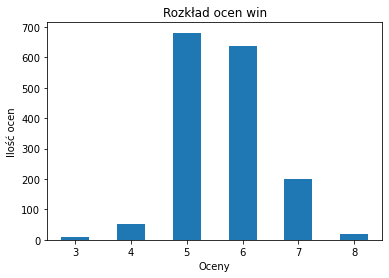

In [87]:
def showGeneralInfo(wine):
    missingValues = wine.isnull().sum().sum()
    numberOfObjects = len(wine)
    print("Ilość brakujących danych: " + str(missingValues))
    print("Ilość obiektów: " + str(numberOfObjects))
    df = wine['quality'].value_counts().sort_index(ascending = True)
    df.plot(kind="bar", rot=0, title="Rozkład ocen win", xlabel="Oceny", ylabel="Ilość ocen")
    print("Atrybuty: ")
    for col in wine.columns: 
        print("\t" + col)

showGeneralInfo(wineRed)

### Przedstawienie informacji o zbiorze win białych

Ilość brakujących danych: 0
Ilość obiektów: 4898
Atrybuty: 
	fixed acidity
	volatile acidity
	citric acid
	residual sugar
	chlorides
	free sulfur dioxide
	total sulfur dioxide
	density
	pH
	sulphates
	alcohol
	quality


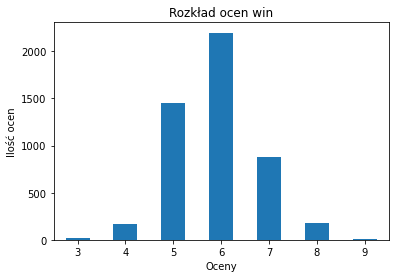

In [88]:
showGeneralInfo(wineWhite)

W obu zbiorach występuje rozkład normalny. Jednakże zbiór win czerwonych charakteryzuje się o wiele mniejszą liczbą obiektów od białego. Dodatkowo w przypadku zbioru białych win, występuje ocena - 'quality' = 9. Dlatego połączenie obu zbiorów może wpłynąć na niekorzyść przyszłych wyników.

### Porównanie win białych i czerwonych

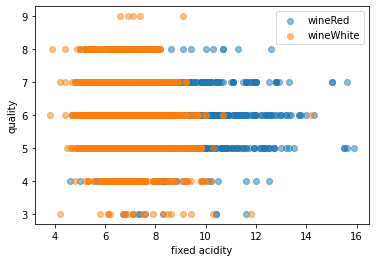

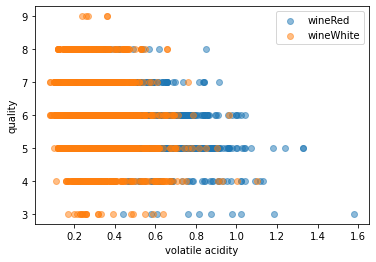

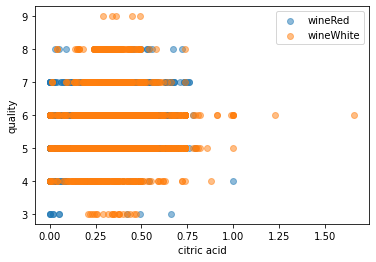

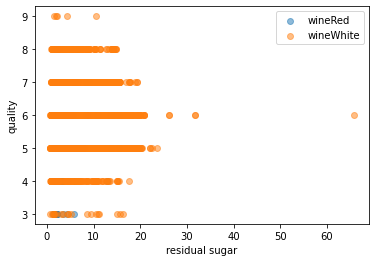

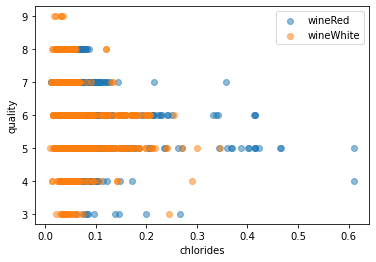

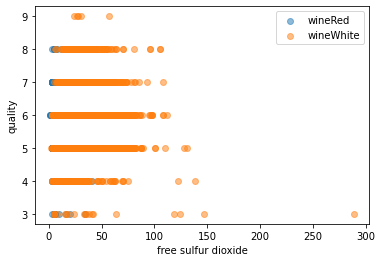

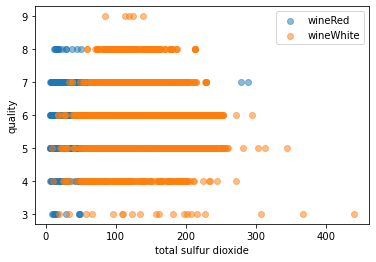

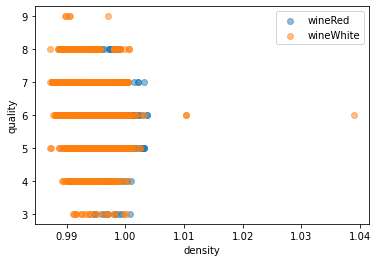

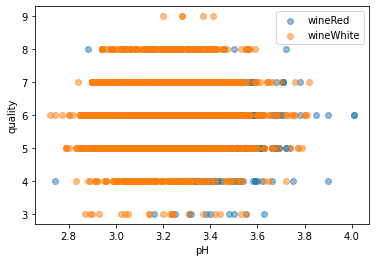

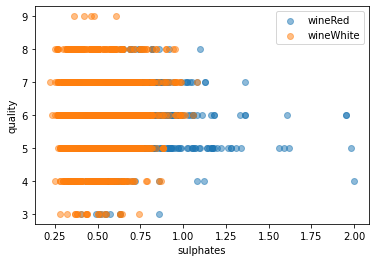

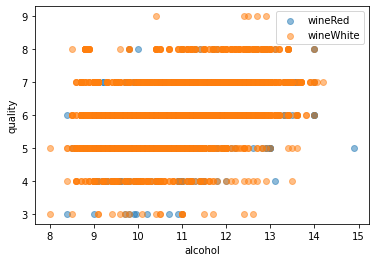

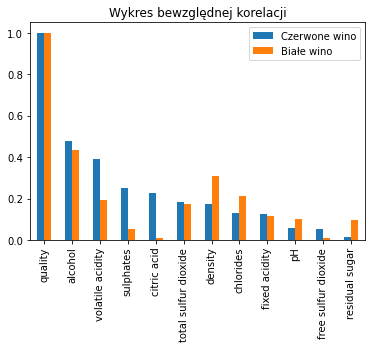

In [106]:
def showWinesComparison(wineRed, wineWhite):
    
    for (x) in wineRed.columns:
        
        if(x != wineWhite[x].name):
            print ("Kolumny się nie pokrywają")
            return False
        elif (x != 'quality'):         
            plt.scatter(wineRed[x], wineRed['quality'], label = 'wineRed', alpha = 0.5)
            plt.scatter(wineWhite[x], wineWhite['quality'], label = 'wineWhite', alpha = 0.5)
            plt.xlabel(x)
            plt.ylabel('quality')
            plt.legend()
            plt.show()
    
    correlationsRed = wineRed.corr()['quality']
    correlationsRed = correlationsRed.abs().sort_values(ascending = False)
    correlationsWhite = wineWhite.corr()['quality']
    correlationsWhite = correlationsWhite.abs().sort_values(ascending = False)
    plotdata = pd.DataFrame({
    "Czerwone wino": correlationsRed,
    "Białe wino": correlationsWhite
    }, index=correlationsRed.index)
    plotdata.plot(kind="bar")
    plt.title("Wykres bewzględnej korelacji")

showWinesComparison(wineRed, wineWhite)

Jako, że intersuje nas jakość, porównaliśmy atrybuty dla obu gatunków win wobec jakości. Po analizie zależności można zauważyć, że wiele danych nie pokrywa się ze sobą. Oznacza to, że konkretne wina posiadają unikalne cechy, które wpływają na jakość. Podobnie można odczytać z wykresu korelacji. Dla czerwonych win bardziej znaczący jest np. atrybut "citric acid", gdzie dla białych win ten atrybut jest praktycznie nieznaczący, małowartościowy. Z drugiej strony dla białego wina znaczącym atrybutem jest "density", gdzie w czerwonym winie posiada o wiele mniejszy wpływ na jakość. Dlatego należy rozpatrywać gatunki win jako osobne zbiory danych.

# Badanie dla zbioru "Red Wine"

### Analiza klasyfikacji atrybutów

<AxesSubplot:>

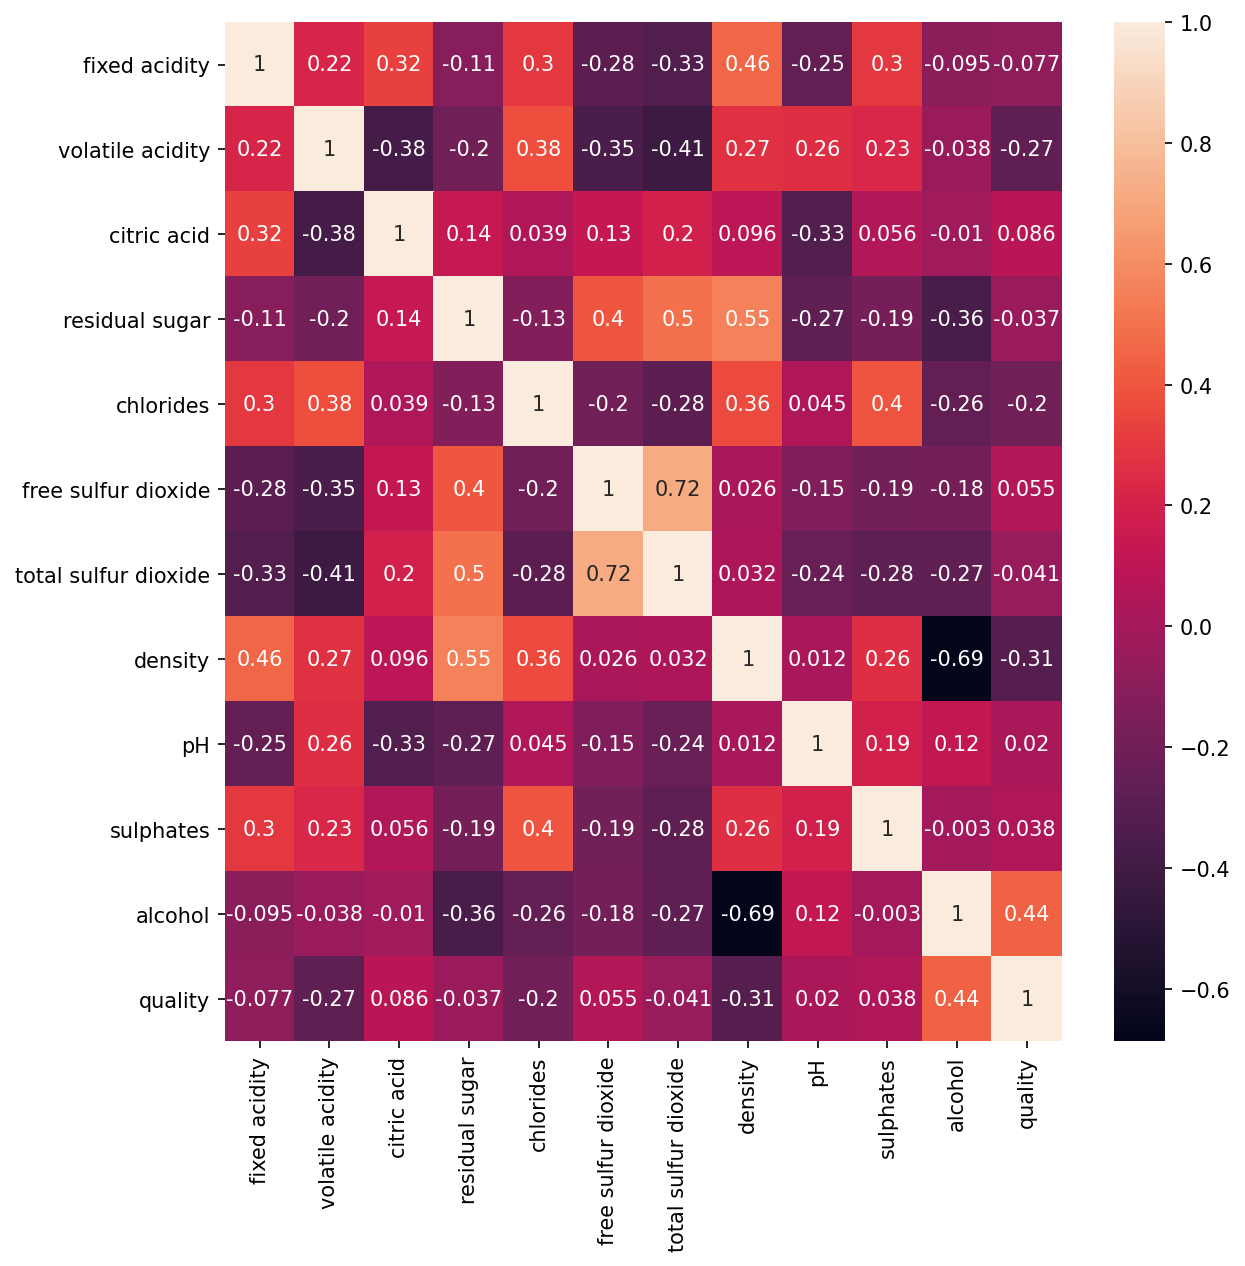

In [12]:
def showCorrelation(wine):
    plt.figure(figsize=(9,9), dpi= 150)
    sns.heatmap(wine.corr(), annot = wine.corr())

showCorrelation(wineRed)

Atrybuty o największym wpływie na jakość wina według kolejności:
	1 - Alcohol
	2 - Volatile acidity
	3 - Sulphates
	4 - Citric acid
	5 - Total sulfur dioxide
	6 - Density
	7 - Chlorides
	8 - Fixed acidity
	9 - Ph
	10 - Free sulfur dioxide


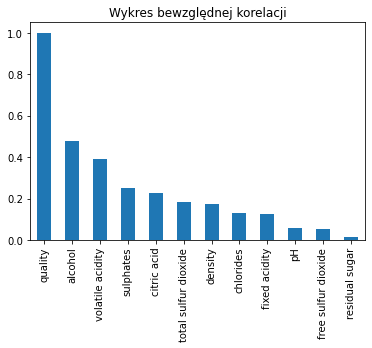

In [130]:
def printCorrelations(wine):
    correlations = wine.corr()['quality']
    correlations = correlations.abs().sort_values(ascending = False)
    correlations.plot(kind = 'bar', title = 'Wykres bewzględnej korelacji')
    print("Atrybuty o największym wpływie na jakość wina według kolejności:")
    for x in range(1, 11):
        if(x < 5):
            print(Fore.RED + "\t" + str(x) + " - " + correlations.index[x].capitalize())
        else:
            print(Fore.BLACK + "\t" + str(x) + " - " + correlations.index[x].capitalize())

printCorrelations(wineRed)

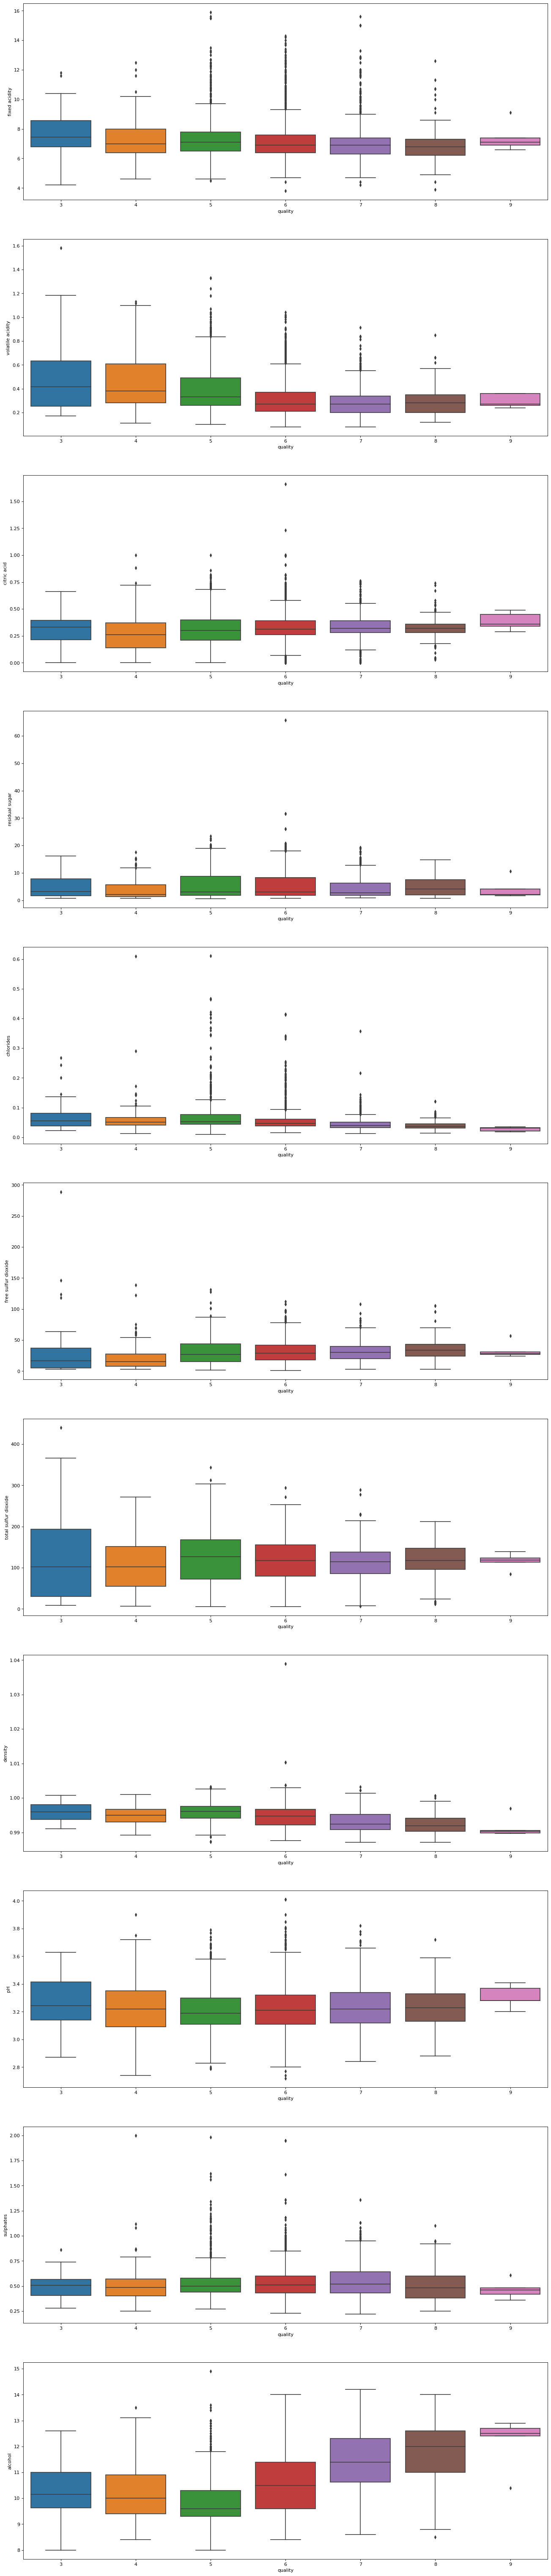

In [14]:
def showBoxPlot(wine):
    y = 1
    plt.figure(figsize=(20,100), dpi= 80)
    for atribute in wine.columns:
        if(atribute=="quality"):
            continue
        plt.subplot(11,1,y)
        sns.boxplot(x="quality", y=atribute, data=wine)
        y+=1
    
showBoxBlot(wineRed)
    

Po wykresach pudełkowych i po macierzy korelacji można zauważyć pewne zależności:

1. Na jakość wina pozytywnie wpływa wzrost alkoholu (alcohol), siarczanów (sulphates) i kwasu cytrynowego (citric acid). Im wyższy jest współczynnik tych atrybutów tym więcej win jest ocenianych pozytywnie. 

Dla alkoholu powyżej 12 % większość win jest oceniana na ocenę 8, która jest najwyższą oceną występującą w naszym zbiorze. 
Dla siarczanów jest to poziom około 0.75 gdzie wina dostają wyższe oceny ( częściowo 6, większość 7-8 ).
Dla kwasu cytrynowego od poziomu 0.4 również oceny win głównie zostają na poziomie 7-8.

2. Negatywnie natomiast na jakość wina wpływają głównie: gęstość (density), pH oraz lotna kwasowość (volatile acidity).

W gęstości różnice są minimalne ale nie zerowe i można zauważyć na wykresie że wina wyżej oceniane mają gęstość znakomo mniejszą.
W pH podobnie jak w gęstości różnice również nie są duże jednak ilość pH w winach lepiej ocenianych jest mniejsza.
W lotnej kwasowości ta różnica jest bardziej widoczna gdyż widać że wina z ocenami 7 i 8 znacząco odstają od reszty ocen w przypadku zmniejszenia wartości tego atrybutu (tą zależność widać również obserwując wysoką korelację z oceną)

Pozostałe atrybuty nie wykazują znaczącego wpływu na ocenę jakości wina.

In [ ]:
Regresja liniowa dla wybranych atrybutów

Dane i wybrane atrybuty
       alcohol  sulphates  volatile acidity  citric acid
0         9.4       0.56             0.700         0.00
1         9.8       0.68             0.880         0.00
2         9.8       0.65             0.760         0.04
3         9.8       0.58             0.280         0.56
4         9.4       0.56             0.700         0.00
...       ...        ...               ...          ...
1594     10.5       0.58             0.600         0.08
1595     11.2       0.76             0.550         0.10
1596     11.0       0.75             0.510         0.13
1597     10.2       0.71             0.645         0.12
1598     11.0       0.66             0.310         0.47

[1599 rows x 4 columns] 0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

Porównanie kilku modeli regresji
                 LinearRegression  RidgeRegression  LassoRegression  ElasticNet
learning_err

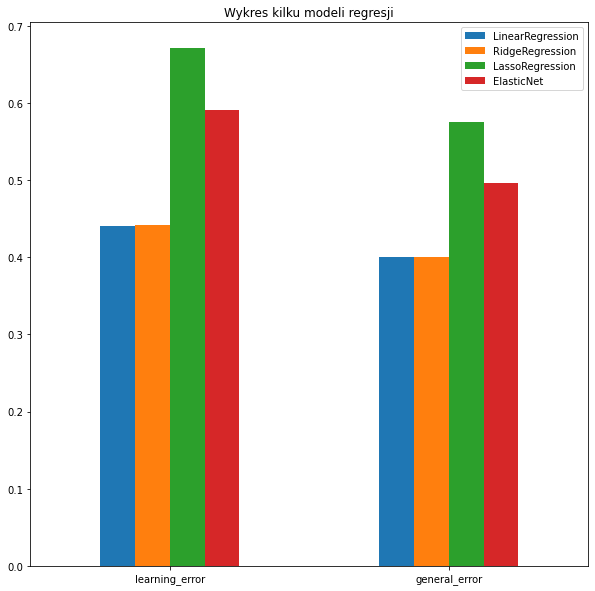

In [23]:

def createRegressionModel(wine,xValues):
    regressor = LinearRegression() 
    #print(wine.columns)
    # x = wine.values #returns a numpy array
    # min_max_scaler = preprocessing.MinMaxScaler()
    # x_scaled = min_max_scaler.fit_transform(wine)
    # df = pd.DataFrame(x_scaled,columns=wine.columns)
    x = wine[xValues]
    y = wine['quality']
    print("Dane i wybrane atrybuty\n", x, y)

    x_ucz, x_test, y_ucz, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

    #Wybranie kilku modelu regresji i wpisanie do hashMapy
    regressors = {}
    regressors['LinearRegression'] = LinearRegression()
    regressors['RidgeRegression'] = Ridge(alpha=0.5) # 0 < alpha < 1
    regressors['LassoRegression'] = Lasso(alpha=5) # alpha > 0
    regressors['ElasticNet'] = ElasticNet(alpha=0.5, l1_ratio = 0.5) # alpha > 0

    #Stworzenie hashMapy zbierającą dane o jakości dobrania
    check_fit = {}

    for type in regressors:
        this_regressor = regressors[type]
        this_regressor.fit(x_ucz,y_ucz) 

        y_pred_ucz = this_regressor.predict(x_ucz)
        e_ucz = metrics.mean_squared_error(y_ucz, y_pred_ucz)
        y_pred_test = this_regressor.predict(x_test)
        e_test = metrics.mean_squared_error(y_test, y_pred_test)
        #clf = svm.SVC(kernel='linear', C=1).fit(x_ucz,y_ucz)
        #scores = cross_val_score(clf, x, y, cv=5)
        #print (clf.score(x_test, y_test))
        check_fit[type] = {"learning_error" : e_ucz, "general_error" : e_test}
    

    #rysowanie wykresu porównującego błędy
    df_for_comparison = pd.DataFrame(check_fit)
    df_for_comparison.plot.bar(rot=0, figsize=(10,10), title = "Wykres kilku modeli regresji")

    print("\nPorównanie kilku modeli regresji\n", df_for_comparison)

xValues = ['alcohol','sulphates','volatile acidity','citric acid']
createRegressionModel(wineRed,xValues)




Najmniejszy błąd uczenia i generalizacji zapewnia regresja liniowa (linear) oraz regresja grzbietowa (ridge). Najlepszym rozwiązaniem jest zatem regresja liniowa.

Czy można uzyskać jeszcze mniejszy błąd uczenia ?

In [26]:

def showErrorOfModels(x,y):
    lm = LinearRegression()
    #k powinno sie znajdowac pomiedzy 5 a 10
    for k_fold in range (6,10):
        scores = cross_val_score(lm, x, y, cv = k_fold, scoring = "neg_mean_squared_error")
        scores = abs(scores)
        #print (scores)
        print ("K = ",k_fold, " Srednia: ", scores.mean())

showErrorOfModels(wineRed[xValues],wineRed["quality"])

K =  6  Srednia:  0.45224135625779255
K =  7  Srednia:  0.44870415157154325
K =  8  Srednia:  0.447344312354782
K =  9  Srednia:  0.4488767084280528
